# This notebook contains the code which prepares training and test datasets for a model trained with the most frequent 'ADJ' + 'NOUN' bigram technique, as well as trains and evaluates this model

## Connect the notebook to MyDrive




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import all necessary libraries

In [3]:
# Standard python libraries for data processing and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NLP packages for text processing
from spacy.lang.en import English
import spacy
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
import re

# Libraries to build, train, evaluate, and save an ML model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import pickle

## Initialize nlp instance and download necessary resources


To be able to use English language models for processing textual data we might need to download them first. <br>
To train the model with the most common 'adj+noun' bigrams feature I used a transformer model with a 438MB size. <br>
To download the transformer model you need to run the following command in the code cell: `!python -m spacy download en_core_web_trf`

In [4]:
nlp = English()
nlp = spacy.load('en_core_web_trf') # tranformer model

## Load train and test datasets


In [5]:
# Import train dataset into pandas DataFrame
train_df = pd.read_csv("drive/MyDrive/python_project/data/train_df.csv")
# Print first 5 rows to see if everything is imported correctly and data is shuffled as we did it at the end of the data-preprocessing notebook
print(train_df.head())

# Import test dataset into pandas DataFrame
test_df = pd.read_csv("drive/MyDrive/python_project/data/test_df.csv")
# Print first 5 rows to see if everything is imported correctly and data is shuffled as we did it at the end of the data-preprocessing notebook
print(test_df.head())

                                            dialogue     name
0   I’ll say it looks good. It’s in my proprietar...  Sheldon
1   Wait, wait, wait. When did you send my mom no...  Leonard
2            I never had a beer with my dad, either.   Howard
3                      My thank you was not sincere.  Sheldon
4   I’m calling to invite you to a spontaneous da...  Sheldon
                                            dialogue     name
0                      Yeah, that’s when it started.  Leonard
1   A million dollars? God, it’s like my nuts jus...   Howard
2   Dinner’s almost ready. If you like meatloaf, ...   Howard
3   Well, Leonard, I think it’s high time you and...  Sheldon
4              All right. It is a comfortable chair.  Sheldon


## Feature engineering

Get top 10 ADJ+NOUN phrase per person with spaCy

In [6]:
# Create a dictionary to store bigram frequencies per name
bigram_freq_per_name = {}

# Iterate over each name in the DataFrame
for name in train_df['name'].unique():
    # Get the dialogues for the current name
    dialogues = train_df.loc[train_df['name'] == name, 'dialogue']

    # Tokenize, lemmatize, and extract adjective + noun bigrams
    all_bigrams = []
    for dialogue in dialogues:
        # Remove punctuation using regex
        dialogue = re.sub(r'[^\w\s]', '', str(dialogue))

        doc = nlp(dialogue.lower())  # Make tokens lowercase
        bigrams = [
            f"{token.lemma_} {token2.lemma_}"
            for token, token2 in zip(doc, doc[1:])
            if token.pos_ == 'ADJ' and token2.pos_ == 'NOUN'
            and token.lemma_.lower() not in STOP_WORDS and token2.lemma_.lower() not in STOP_WORDS
        ]
        all_bigrams.extend(bigrams)

    # Calculate the bigram frequencies
    bigram_freq = Counter(all_bigrams)

    # Store the bigram frequencies for the current name
    bigram_freq_per_name[name] = bigram_freq.most_common(10)  # Change the number to get more or fewer common bigrams

# Print the top 10 'adjective' + 'noun' bigrams per name
for name, freq_bigrams in bigram_freq_per_name.items():
    print(f"Top 10 'adjective' + 'noun' bigrams for {name}:")
    for bigram, freq in freq_bigrams:
        print(f"- {bigram}: {freq}")
    print()

Top 10 'adjective' + 'noun' bigrams for Sheldon:
- good night: 15
- good friend: 8
- good thing: 7
- hot dog: 6
- good morning: 6
- eidetic memory: 5
- good idea: 5
- good luck: 5
- dark matter: 4
- subatomic particle: 4

Top 10 'adjective' + 'noun' bigrams for Leonard:
- good night: 12
- big deal: 10
- little bit: 7
- long time: 6
- good friend: 6
- good time: 6
- good thing: 5
- good luck: 5
- nice guy: 4
- dark matter: 4

Top 10 'adjective' + 'noun' bigrams for Howard:
- good friend: 10
- big deal: 6
- good idea: 6
- good news: 6
- international space: 5
- grown man: 5
- hot dog: 4
- red light: 4
- long time: 4
- good job: 4

Top 10 'adjective' + 'noun' bigrams for Penny:
- good night: 12
- big deal: 11
- soft kitty: 10
- high school: 10
- good friend: 7
- warm kitty: 7
- little ball: 6
- pharmaceutical sale: 5
- big thing: 5
- grown man: 5



### Get unique 'adj+noun' bigrams

In [11]:
# Get all the values of the bigram_freq_per_name dictionary which are tuple of 'adj+noun' bigrams and their frequencies
adj_noun_freq_list = bigram_freq_per_name.values()
# bigram_freq_per_name is the list of lists of 'adj+noun' bigrams + frequency tuples
# To get only 'add+noun' bigrams without frequencies we need to iterate through the list of lists of 'add+noun' bigrams + frequency tuples and then through lists of 'adj+noun' bigrams + frequency tuples and get the first element of the tuple
# For this we used a list comprehension
freq_adj_noun = [adj_noun_freq[0] for adj_noun_freqs in adj_noun_freq_list for adj_noun_freq in adj_noun_freqs]
# To get only unique 'adj+noun' bigrams we cast the list of 'adj+noun' bigrams into a set and then cast it back to a list
unique_freq_adj_nouns = list(set(freq_adj_noun))
# Print the list and length of unique 'adj+noun' bigrams
print(unique_freq_adj_nouns)
print(len(unique_freq_adj_nouns))

['big deal', 'good job', 'good morning', 'dark matter', 'good time', 'hot dog', 'big thing', 'good idea', 'good luck', 'high school', 'red light', 'good night', 'good news', 'good friend', 'pharmaceutical sale', 'little bit', 'long time', 'soft kitty', 'little ball', 'grown man', 'warm kitty', 'nice guy', 'international space', 'subatomic particle', 'eidetic memory', 'good thing']
26


## Prepare train and test datasets for the logistic regression model to be trained with adj+noun bigrams technique

In [12]:
# Get a list of dialogues and names from the train dataset
train_dialogues = train_df['dialogue'].astype(str).apply(lambda x: x.lower()).to_list()
train_names = train_df['name'].astype(str).apply(lambda x: x.lower()).to_list()
print(train_dialogues[:5])
print(train_names[:5])

# Get a list of dialogues and names from the test dataset
test_dialogues = test_df['dialogue'].astype(str).apply(lambda x: x.lower()).to_list()
test_names = test_df['name'].astype(str).apply(lambda x: x.lower()).to_list()
print(test_dialogues[:5])
print(test_names[:5])

[' i’ll say it looks good. it’s in my proprietary font, shelvetica.', ' wait, wait, wait. when did you send my mom notes on a paper?', ' i never had a beer with my dad, either.', ' my thank you was not sincere.', ' i’m calling to invite you to a spontaneous date night tomorrow evening.']
['sheldon', 'leonard', 'howard', 'sheldon', 'sheldon']
[' yeah, that’s when it started.', ' a million dollars? god, it’s like my nuts just kicked me in the nuts. that’s it, i got to start earning more money right now.', ' dinner’s almost ready. if you like meatloaf, i’m sure you’ll like its cousin, bowl of meat.', ' well, leonard, i think it’s high time you and i address the tweepadock in the room.', ' all right. it is a comfortable chair.']
['leonard', 'howard', 'howard', 'sheldon', 'sheldon']


In [13]:
# Get train numpy array with values as zeros in the shape of train_dialogues length * unique_freq_nouns length
train_features = np.zeros((len(train_dialogues), len(unique_freq_adj_nouns)))

# Print the shape of this 2d array
print(train_features.shape)

# Get test numpy array with values as zeros in the shape of train_dialogues length * unique_freq_nouns length
test_features = np.zeros((len(test_dialogues), len(unique_freq_adj_nouns)))

# Print the shape of this 2d array
print(test_features.shape)

(18468, 26)
(4596, 26)


Fill in the train_features and test_features with 1 if the adj+noun phrase is in the dialogue


In [14]:
# Initialize a train_doc_dialogues generator
train_doc_dialogues = nlp.pipe(train_dialogues)

# Iterate throguh train_doc_dialogues generator and train_features numpy array
for dialogue, f in zip(train_doc_dialogues, train_features):
    # create a bigrams list of all words in the dialogue
    bigrams_list = []
    for i in range(len(dialogue) - 1):
        if dialogue[i].pos_ == 'ADJ' and dialogue[i+1].pos_ == 'NOUN':
            bigram = f"{dialogue[i].lemma_} {dialogue[i+1].lemma_}"
            bigrams_list.append(bigram)
    # iterate through the list of unique 'adj+noun' bigrams
    for bigram in unique_freq_adj_nouns:
        # if the noun in the tokens list
        if bigram in bigrams_list:
            # get the index number of it
            bigram_id = unique_freq_adj_nouns.index(bigram)
            # replace the value of the feature array at the given index with 1
            f[bigram_id] = 1

In [15]:
# Initialize a test_doc_dialogues generator
test_doc_dialogues = nlp.pipe(test_dialogues)

# Iterate throguh test_doc_dialogues generator and test_features numpy array
for dialogue, f in zip(test_doc_dialogues, test_features):
    # create a bigrams list of all words in the dialogue
    bigrams_list = []
    for i in range(len(dialogue) - 1):
        if dialogue[i].pos_ == 'ADJ' and dialogue[i+1].pos_ == 'NOUN':
            bigram = f"{dialogue[i].lemma_} {dialogue[i+1].lemma_}"
            bigrams_list.append(bigram)
    # iterate through the list of unique 'adj+noun' bigrams
    for bigram in unique_freq_adj_nouns:
        # if the noun in the tokens list
        if bigram in bigrams_list:
            # get the index number of the noun in the unique nouns list
            bigram_id = unique_freq_adj_nouns.index(bigram)
            # replace the value of the feature array at the given index with 1
            f[bigram_id] = 1

### Train the model with the most common adj+noun bigrams feature

In [16]:
# Make an instance of the Model from LogisticRegression class
lr_adj_noun_model = LogisticRegression()

# Train the model
lr_adj_noun_model.fit(train_features, train_names)

# Print the labels
print(lr_adj_noun_model.classes_)

# Print parameters of the model
print(lr_adj_noun_model.get_params())

['howard' 'leonard' 'penny' 'sheldon']
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Save the logistic regression model to be trained with adj+noun bigrams technique



In [17]:
with open("drive/MyDrive/python_project/lr_adj_noun_model.pkl", 'wb') as file:
    pickle.dump(lr_adj_noun_model, file)

### Get predictions

In [19]:
# Define a funtion that will take the index of the dialogue in the test features and predict the name to whom this dialogue might belong
def getPrediction(model):
    predictions = model.predict(test_features)
    return predictions

## Evaluate the logistic regression model trained with adj+noun bigrams feature



### Accuracy

In [20]:
# Get prediction of all dialogues
predictions_lr = getPrediction(lr_adj_noun_model)
# Use accuracy_score funtion to calculate the accuracy
accuracy = accuracy_score(test_names, predictions_lr)
# Print the accuracy
print("Accuracy of the model trained with Adj + Noun bigram feature:", accuracy)

Accuracy of the model trained with Adj + Noun bigram feature: 0.2530461270670148


### Confusion matrix visualization

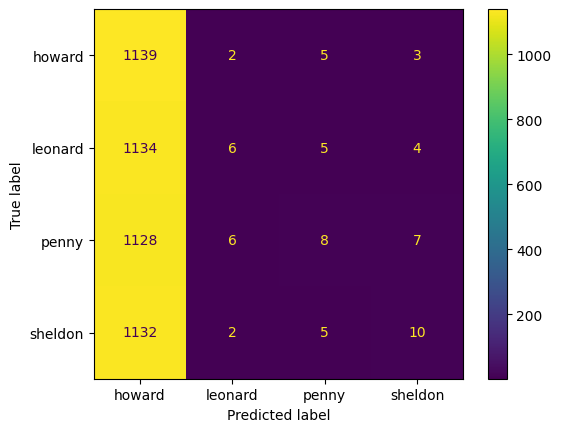

In [21]:
# Get the labels
labels = lr_adj_noun_model.classes_
# Get the confusion matrix
cm = confusion_matrix(test_names, predictions_lr, labels=labels)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

### Get classification report

In [22]:
# Print the classification report
print(classification_report(test_names, predictions_lr))

              precision    recall  f1-score   support

      howard       0.25      0.99      0.40      1149
     leonard       0.38      0.01      0.01      1149
       penny       0.35      0.01      0.01      1149
     sheldon       0.42      0.01      0.02      1149

    accuracy                           0.25      4596
   macro avg       0.35      0.25      0.11      4596
weighted avg       0.35      0.25      0.11      4596

